# Receiving weather API data and inserting into Database

## This projects use following Libraries:
- requests==2.31.0
- pandas==2.1.4
- geopandas==0.14.1
- DateTime==5.4
- matplotlib==3.8.2
- folium==0.15.1
- mapclassify==2.6.1


In [1]:
import os
import requests
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
import json

## API KEY From https://openweathermap.org/

In [2]:
with open("venv/API.txt", "r") as file:
    API_KEY = file.read().strip()

## Building code for getting API to JSON

In [3]:
## make code for inputting city
# city = input("Enter a city name: ")
city = "Jakarta" # Default city is Jakarta

# API calling format to change city and use API KEY
BASE_URL = "http://api.openweathermap.org/data/2.5/weather"
request_url = f"{BASE_URL}?appid={API_KEY}&q={city}"
response = requests.get(request_url)

# to make sure the response is correct
if response.status_code == 200:
    data = response.json()
    print("Data Accepted.")
else:
    print(f"Error {response.status_code}: {response.text}")



Data Accepted.


## Cleansing JSON Data

In [4]:
# analyze the response API data
print(data)

{'coord': {'lon': 106.8451, 'lat': -6.2146}, 'weather': [{'id': 721, 'main': 'Haze', 'description': 'haze', 'icon': '50d'}], 'base': 'stations', 'main': {'temp': 306.32, 'feels_like': 313.32, 'temp_min': 303.38, 'temp_max': 307.16, 'pressure': 1006, 'humidity': 77}, 'visibility': 5000, 'wind': {'speed': 5.14, 'deg': 20}, 'clouds': {'all': 40}, 'dt': 1703753846, 'sys': {'type': 1, 'id': 9383, 'country': 'ID', 'sunrise': 1703716758, 'sunset': 1703761686}, 'timezone': 25200, 'id': 1642911, 'name': 'Jakarta', 'cod': 200}


In [5]:
# Get Coordinate
Lat = data['coord']['lat']
Long = data['coord']['lon']

# Convert Unix time to Datetime
Date = str(datetime.datetime.fromtimestamp(data['dt']).strftime('%Y-%m-%d %H:%M:%S'))

# Get weather data
City_Name = data['name']
Temp_Avg = round(((data['main']['temp_max']+data['main']['temp_min'])/2)- 273.15,2) # Converting Kelvin to Celsius
Pressure = data['main']['pressure']
Humidity = data['main']['humidity']
Wind_spd = data['wind']['speed']
Wind_deg = data['wind']['deg']
Cloud_Percent = data['clouds']['all']

### Validating the data

In [6]:
# Formating from JSON to Pandas Dataframe
Data_Clean = pd.DataFrame({
    'Date': Date,
    'City': City_Name,
    'Temp_Avg': str(Temp_Avg) + " Celcius",
    'Pressure': Pressure,
    'Humidity': str(Humidity) + " %",
    'Wind_spd': Wind_spd,
    'Wind_deg': Wind_deg,
    'Cloud': str(Cloud_Percent) + " %",
    'Long': Long,
    'Lat': Lat,}
    , index=[0])

print("After cleansing data from API.")
print(Data_Clean)

After cleansing data from API.
                  Date     City       Temp_Avg  Pressure Humidity  Wind_spd  \
0  2023-12-28 15:57:26  Jakarta  32.12 Celcius      1006     77 %      5.14   

   Wind_deg Cloud      Long     Lat  
0        20  40 %  106.8451 -6.2146  


### Visualize data from API

In [7]:
# Location
crs = {'init':'epsg:4326'}
geo_data = Data_Clean
Data_Clean['geometry'] = gpd.points_from_xy(Data_Clean['Long'], Data_Clean['Lat'])
geo_data = gpd.GeoDataFrame(Data_Clean, crs=crs, geometry=Data_Clean['geometry'])
geo_data.explore()
# Wind Speed and direction

# Temperature, Pressure, Humidity, and Cloud

c:\Project Coding\Python\weather API\venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## inserting to Databases

In [8]:
# Convert the DataFrame to a dictionary and then to JSON
if 'geometry' in Data_Clean.columns:
    Data_Clean = pd.DataFrame(Data_Clean.drop(columns='geometry'))
JSON_Data = Data_Clean.to_dict(orient='records')

# Export JSON data to a file
try:
    file_path = 'datastorage/weatherdata.json'
    # Checking weather data storage
    if os.path.exists(file_path):
        print("File exists. Appending data.")
        Data_Clean['Date'] = pd.to_datetime(Data_Clean['Date'])
        Data_Existing = pd.read_json(file_path)

        Data_Merged = pd.concat([Data_Clean,Data_Existing], ignore_index=True)
        print(Data_Merged)
        print(Data_Merged.dtypes)

        Data_Merged = Data_Merged.to_json(orient = 'records')
        print(Data_Merged)

        with open(file_path, 'w') as JSON_File:
            json.dump(json.loads(Data_Merged), JSON_File)
        print("DataFrame exported to JSON successfully.")

    # if data not available, make a new one
    else:
        with open(file_path, 'w') as JSON_File:
            json.dump(JSON_Data, JSON_File)
        print("DataFrame exported to JSON successfully.")

# Printing error that occured if existed
except Exception as e:
    print(f"Error: {e}")

File exists. Appending data.
                  Date     City       Temp_Avg  Pressure Humidity  Wind_spd  \
0  2023-12-28 15:57:26  Jakarta  32.12 Celcius      1006     77 %      5.14   
1  2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
2  2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
3  2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
4  2023-12-28 13:43:33  Jakarta   32.0 Celcius      1010     70 %      7.72   
5  2023-12-28 13:35:35  Jakarta   34.1 Celcius      1008     77 %      5.14   
6  2023-12-28 13:25:12  Jakarta  33.25 Celcius      1009     77 %      5.14   
7  2023-12-28 13:15:02  Jakarta   33.6 Celcius      1009     69 %      5.14   
8  2023-12-28 12:43:08  Jakarta  34.29 Celcius      1009     70 %      5.14   
9  2023-12-28 10:57:52  Jakarta  33.33 Celcius      1010     72 %      1.54   
10 2023-12-27 15:20:27  Jakarta  31.53 Celcius      1009     68 %      3.09   

    Wind_deg Cloud    

## Visualizing time series data from databases

### Load JSON format data and covert into DataFrame

In [9]:
Dataset = pd.read_json(file_path)
print(Dataset)
print(Dataset.dtypes)


                  Date     City       Temp_Avg  Pressure Humidity  Wind_spd  \
0  2023-12-28 15:57:26  Jakarta  32.12 Celcius      1006     77 %      5.14   
1  2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
2  2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
3  2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
4  2023-12-28 13:43:33  Jakarta   32.0 Celcius      1010     70 %      7.72   
5  2023-12-28 13:35:35  Jakarta   34.1 Celcius      1008     77 %      5.14   
6  2023-12-28 13:25:12  Jakarta  33.25 Celcius      1009     77 %      5.14   
7  2023-12-28 13:15:02  Jakarta   33.6 Celcius      1009     69 %      5.14   
8  2023-12-28 12:43:08  Jakarta  34.29 Celcius      1009     70 %      5.14   
9  2023-12-28 10:57:52  Jakarta  33.33 Celcius      1010     72 %      1.54   
10 2023-12-27 15:20:27  Jakarta  31.53 Celcius      1009     68 %      3.09   

    Wind_deg Cloud      Long     Lat  
0         20

### Building geometry to visualize Coordinate dataset

In [10]:
# Define CRS
CRS = {'init':'epsg:4326'}

Dataset['geometry'] = gpd.points_from_xy(Dataset['Long'], Dataset['Lat'])
GeoDataset = gpd.GeoDataFrame(Dataset, crs=crs, geometry=Dataset['geometry'])
GeoDataset['Date'] = GeoDataset['Date'].dt.strftime("%Y-%m-%d %H:%M:%S")
print(GeoDataset)
GeoDataset.explore()

                   Date     City       Temp_Avg  Pressure Humidity  Wind_spd  \
0   2023-12-28 15:57:26  Jakarta  32.12 Celcius      1006     77 %      5.14   
1   2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
2   2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
3   2023-12-28 13:57:01  Jakarta   32.0 Celcius      1010     70 %      7.72   
4   2023-12-28 13:43:33  Jakarta   32.0 Celcius      1010     70 %      7.72   
5   2023-12-28 13:35:35  Jakarta   34.1 Celcius      1008     77 %      5.14   
6   2023-12-28 13:25:12  Jakarta  33.25 Celcius      1009     77 %      5.14   
7   2023-12-28 13:15:02  Jakarta   33.6 Celcius      1009     69 %      5.14   
8   2023-12-28 12:43:08  Jakarta  34.29 Celcius      1009     70 %      5.14   
9   2023-12-28 10:57:52  Jakarta  33.33 Celcius      1010     72 %      1.54   
10  2023-12-27 15:20:27  Jakarta  31.53 Celcius      1009     68 %      3.09   

    Wind_deg Cloud      Long     Lat   

c:\Project Coding\Python\weather API\venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Filtering dataset for specific city/location

In [11]:
## Code to input desired city
# Filter_City = input('Input a City: ')
Filter_City = 'Jakarta' #Default filtered city is Jakarta
Dataset_Filtered = Dataset[Dataset['City'] == Filter_City]

if Dataset_Filtered.empty:
    # Print console if dataset is empty
    print("Data not available.")

else:
    # Cleansing data to dd-mm-yy format
    Dataset_Filtered['Date'] = Dataset_Filtered['Date'].dt.strftime('%d-%m-%Y')

    # Removing Geometry data if available
    if 'geometry' in Dataset_Filtered.columns:
        Dataset_Filtered = pd.DataFrame(Dataset_Filtered.drop(columns='geometry'))

    # Removing city column because its object that cannot use by .mean()
    if 'City' in Dataset_Filtered.columns:
        Dataset_Filtered = pd.DataFrame(Dataset_Filtered.drop(columns='City'))

    # Converting the object data value to numeric value
    convert_columns = ['Temp_Avg', 'Humidity', 'Cloud']
    for column in convert_columns:
        Dataset_Filtered[column] = Dataset_Filtered[column].astype(str).str.extract(r'(\d+\.\d+)').astype(float)

    # Averaging data by date
    Dataset_Filtered = Dataset_Filtered.groupby('Date').mean().reset_index()

    numeric_columns = ['Temp_Avg', 'Pressure', 'Humidity', 'Wind_spd', 'Wind_deg', 'Cloud', 'Long', 'Lat']
    Dataset_Filtered[numeric_columns] = Dataset_Filtered[numeric_columns].round(2)

    # Adding city data by filtered city
    Dataset_Filtered['City'] = Filter_City

### Plotting by date with Temperature, Humidity, Pressure, and Cloud Visibility

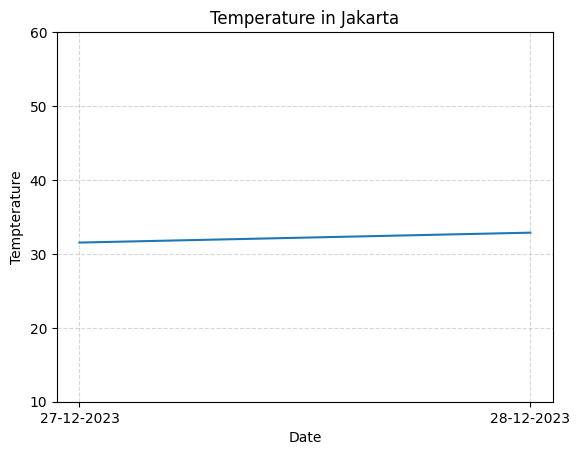

In [12]:
fig, ax = plt.subplots()

# Define data to plotting
ax.plot(Dataset_Filtered['Date'],
        Dataset_Filtered['Temp_Avg'])

# Configure the label and title figure
ax.set(xlabel='Date',
       ylabel='Tempterature',
       title=f"Temperature in {Filter_City}")

# Configure grid to visualize the y axis grid
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2, linestyle=':')
ax.grid(which='major', alpha=0.5, linestyle='--')
ax.set_ylim([10, 60])

plt.show()

## Display on Tkinter